In [1]:
import json
import pandas as pd
from collections import defaultdict
from scipy.stats import hypergeom
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#path for summary of AlphaFolfd structures
reference_summary_path='../data/csv/summary_reference.csv'
isoform_summary_path='../data/csv/summary_isoform.csv'

#path for isoform and reference go
reference_go_path='../data/json/reference_go.json'
isoform_go_path='../data/json/isoform_go.json'

#path for the predicted probability for each go term, this is provided with the paper on figshare
reference_go_prob_path='../data/tsv/reference/structure.tsv'
isoform_go_prob_path='../data/tsv/isoform/structure.tsv'

#path for as event
as_event_path='../data/json/as_event.json'

#path for go obo database file,download from https://geneontology.org/
go_obo_path='../data/obo/go.obo'

<span style="font-size: 20px;">Plot for alternative splicing type affect gain/loss of function:</span>

In [3]:
def load_file_json(path):
    with open(path,'r') as load_f:
        file=json.load(load_f)
    return file

In [4]:
def read_data_from_file(file_path):
    with open(file_path, 'r') as file:
        data = file.readlines()
    return data

In [5]:
reference_go=load_file_json(reference_go_path)
isoform_go=load_file_json(isoform_go_path)
as_event=load_file_json(as_event_path)

In [17]:
#unique_list

In [6]:
isoform_summary=pd.read_csv(isoform_summary_path)
reference_summary=pd.read_csv(reference_summary_path)

In [7]:
#add the prediction quality, used for filter out low prediction quality structure
def add_quality(isoform_go,reference_go,isoform_summary,reference_summary):
    new_isoform_go={}
    new_reference_go={}
    for isoform in isoform_go.keys():
        if isoform in list(isoform_summary['isoform']):
            sub_isoform_df=isoform_summary[isoform_summary['isoform']==isoform].reset_index(drop=True)
            isoform_plddt=sub_isoform_df['plddt'][0]
            if float(isoform_plddt)>=70.0:
                new_isoform_go[isoform]=isoform_go[isoform]
    for reference in reference_go.keys():
        if reference in list(reference_summary['reference']):
            sub_reference_df=reference_summary[reference_summary['reference']==reference].reset_index(drop=True)
            reference_plddt=sub_reference_df['plddt'][0]
            if float(reference_plddt)>=70.0:
                new_reference_go[reference]=reference_go[reference]
    return new_isoform_go,new_reference_go
isoform_go_high_confident,reference_go_high_confident=add_quality(isoform_go,reference_go,isoform_summary,reference_summary)

In [8]:
#calculate the total number of go terms in the high and confident dataset, will be used in the hypergeometric test 
def count_go_dic(isoform_go_high_confidnet,reference_go_high_confident):
    count_isoform_go_dic = defaultdict(int)
    count_reference_go_dic = defaultdict(int)
    count_total_go_dic = defaultdict(int)
    for go_list in isoform_go_high_confident.values():
        for go in set(go_list):
            count_isoform_go_dic[go]+=1
            count_total_go_dic[go]+=1
            
    for go_list in reference_go_high_confident.values():
        for go in set(go_list):
            count_reference_go_dic[go]=+1
            count_total_go_dic[go]+=1
    return dict(count_isoform_go_dic),dict(count_reference_go_dic),dict(count_total_go_dic)

In [9]:
count_isoform_go_dic,count_reference_go_dic,count_total_go_dic=count_go_dic(isoform_go_high_confident,reference_go_high_confident)

In [6]:
#select the isoform with annotated alternative splicing types
def add_quality_type(isoform_go,reference_go,isoform_summary,reference_summary,as_event):
    new_isoform_go={}
    for isoform in isoform_go.keys():
        if isoform in list(isoform_summary['isoform']) and isoform.split('-')[0] in list(reference_summary['reference']):
            sub_isoform_df=isoform_summary[isoform_summary['isoform']==isoform].reset_index(drop=True)
            isoform_plddt=sub_isoform_df['plddt'][0]
            sub_reference_df=reference_summary[reference_summary['reference']==isoform.split('-')[0]].reset_index(drop=True)
            reference_plddt=sub_reference_df['plddt'][0]
            if float(isoform_plddt)>=70.0 and float(reference_plddt)>=70.0 and isoform in as_event.keys():
                if type(as_event[isoform])==list:
                    new_isoform_go[isoform]=isoform_go[isoform]
    return new_isoform_go

In [11]:
isoform_go_type=add_quality_type(isoform_go,reference_go,isoform_summary,reference_summary,as_event)

In [7]:
def unique_to_list(list1, list2):
    set1 = set(list1)
    set2 = set(list2)
    unique_elements = set1.difference(set2)
    unique_elements_list = list(unique_elements)
    return unique_elements_list

In [8]:
#get the gain/loss of GO terms for each isoform
def function_change_df(as_event,isoform_go,reference_go):
    index_list=[]
    for isoform in isoform_go.keys():
        for go in isoform_go[isoform]:
            if go not in index_list:
                index_list.append(go)
    for reference in reference_go.keys():
        for go in reference_go[reference]:
            if go not in index_list:
                index_list.append(go)
    column_names=['exon_skipping','alternative_donor_site','alternative_acceptor_site',
         'intron_retention','mutually_exclusive_exon','alternative_first_exon','alternative_last_exon',
         'mutually_exclusive_exon-alternative_first_exon','mutually_exclusive_exon-alternative_last_exon']
    gain_function_df=pd.DataFrame(index=index_list,columns=column_names)
    lose_function_df=pd.DataFrame(index=index_list,columns=column_names)
    gain_function_df = gain_function_df.fillna(0)
    lose_function_df = lose_function_df.fillna(0)
    for isoform in as_event:
        reference=isoform.split('-')[0]
        as_type=list(set(as_event[isoform]))
        if isoform in isoform_go.keys() and reference in reference_go.keys():
            gain_go_list=unique_to_list(isoform_go[isoform],reference_go[reference])
            lose_go_list=unique_to_list(reference_go[reference],isoform_go[isoform])
            if type(as_event[isoform])==list:
                for event in as_type:
                    if gain_go_list!=[]:
                        for go in gain_go_list:
                            gain_function_df[event][go]+=1
                    if lose_go_list!=[]:
                        for go in lose_go_list:
                            lose_function_df[event][go]+=1
    gain_function_df = gain_function_df[(gain_function_df != 0).any(axis=1)]
    lose_function_df = lose_function_df[(lose_function_df != 0).any(axis=1)]
    return gain_function_df,lose_function_df

In [14]:
gain_function,lose_function=function_change_df(as_event,isoform_go_high_confident,reference_go_high_confident)

In [15]:
#hypergeometric test
def hyper_test(function_change_df,isoform_go_quality_type,as_event):
    function_change_df_pval=function_change_df.copy()
    isoform_all=len(isoform_go_quality_type)
    for index in function_change_df.index:
        isoform_change_all=function_change_df.loc[index].sum()
        for event in function_change_df.columns:
            isoform_change_as=function_change_df[event][index]
            isoform_as=0
            for isoform in isoform_go_quality_type.keys():
                if event in as_event[isoform]:
                    isoform_as+=1
            pval = hypergeom.sf(isoform_change_as-1, isoform_all, isoform_as, isoform_change_all)
            function_change_df_pval[event][index]=pval
    return function_change_df_pval

In [16]:
gain_function_pval=hyper_test(gain_function,isoform_go_type,as_event)
lose_function_pval=hyper_test(lose_function,isoform_go_type,as_event)

/tmp/ipykernel_2703700/90651819.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  function_change_df_pval[event][index]=pval


In [17]:
#filter out go terms with too few gain/loss, and also filter some general GO terms
def filter_go(change_function_df,change_function_df_pval,count_total_go_dic,pval_threshould,count_threshold,background_threshold):
    go_list=[]
    sign_change_function_df_pval=change_function_df_pval[(change_function_df_pval < pval_threshould).any(axis=1)]
    for index in sign_change_function_df_pval.index:
        for column in sign_change_function_df_pval.columns:
            if sign_change_function_df_pval[column][index]<pval_threshould:
                selected_row = change_function_df.loc[index]
                go_count=selected_row[column]
                if go_count>count_threshold and count_total_go_dic[index]<background_threshold:
                    go_list.append(index)
    sign_change_function_df_pval=sign_change_function_df_pval.loc[go_list]
    return sign_change_function_df_pval
sign_gain_function=filter_go(gain_function,gain_function_pval,count_total_go_dic,0.05,5,10000)
sign_lose_function=filter_go(lose_function,lose_function_pval,count_total_go_dic,0.05,10,10000)

In [9]:
def extract_name_and_namespace(go_data, go_id,go_name=False):
    term = None
    in_term = False
    for line in go_data:
        line = line.strip()
        if line.startswith('[Term]'):
            in_term = True
            term = {'id': None, 'name': None, 'namespace': None}
        elif in_term and line.startswith('id: '):
            term['id'] = line.split(': ')[1]
        elif in_term and line.startswith('name: '):
            term['name'] = line.split(': ')[1]
        elif in_term and line.startswith('namespace: '):
            term['namespace'] = line.split(': ')[1]
        if go_id!=False:
            if term and line == '' and term['id'] == go_id:
                return term['name'], term['namespace']
        else:
            if term and line == '' and term['name'] == go_name:
                return term['id'], term['namespace']
    return None, None

In [19]:
def replace_name_df(change_function_df):
    new_column_names = ['Exon skipping', 'Alternative donor site', 'Alternative acceptor site',
                        'Intron retention','Mutually exclusive exon','Alternative first exon',
                        'Alternative last exon','Mutually Exclusive Exon'+'\n'+'Alternative First Exon',
                        'Mutually exclusive exon'+'\n'+'Alternative last exon']
    change_function_df.columns = new_column_names
    return change_function_df
sign_gain_function=replace_name_df(sign_gain_function)
sign_lose_function=replace_name_df(sign_lose_function)

In [19]:
go_obo=read_data_from_file(go_obo_path)

In [21]:
def remove_obsolete_df(go_data,change_function_df):
    new_index_list=[]
    for index in change_function_df.index:
        term_name=extract_name_and_namespace(go_data,index)[0]
        new_index=term_name
        new_index_list.append(new_index)
    change_function_df = change_function_df.reset_index(drop=True)
    change_function_df['index']=new_index_list
    change_function_df = change_function_df.set_index('index')
    mask = change_function_df.index.str.contains('obsolete')
    change_function_df_filtered = change_function_df[~mask]
    return change_function_df_filtered
sign_gain_function_name=remove_obsolete_df(go_obo,sign_gain_function)
sign_lose_function_name=remove_obsolete_df(go_obo,sign_lose_function)

In [22]:
def remove_dup_df(change_function_df):
    indices_to_remove = []    
    for i in change_function_df.index:
        for j in change_function_df.index:
            if i==j:
                continue
            if i in j:
                indices_to_remove.append(i)
    change_function_df = change_function_df.drop(indices_to_remove)
    #change_function_df = change_function_df.reset_index(drop=True)
    return change_function_df

In [23]:
sign_gain_function_name=remove_dup_df(sign_gain_function_name)

In [24]:
sign_lose_function_name=remove_dup_df(sign_lose_function_name)

In [10]:
def get_sub_go_list(go_data,change_function_df):
    sub_go_list=[]
    for index in change_function_df.index:
        term_namespace=extract_name_and_namespace(go_data,go_id=False,go_name=index)[1]
        if term_namespace=='biological_process':
            term_namespace='Biological process'
        elif term_namespace=='cellular_component':
            term_namespace='Cellular component'
        else:
            term_namespace='Molecular function'
        sub_go_list.append(term_namespace)
    return sub_go_list

In [11]:
def cluster_plot(go_data,change_function_df):
    #plt.figure(figsize=(1,5))
    category_colors = {'Biological process': 'blue','Cellular component': 'orange','Molecular function': 'green'}
    clustergrid=sns.clustermap(change_function_df,figsize=(12,20),dendrogram_ratio=(.15, .1),
                           tree_kws=dict(linewidths=4),col_cluster=False,cmap='rocket_r') 
    clustergrid.cax.set_visible(False)

    clustergrid.ax_heatmap.set_ylabel('')
    ytick_labels = clustergrid.ax_heatmap.get_yticklabels()
    clustered_function_df=clustergrid.data2d
    sub_go_list=get_sub_go_list(go_data,clustered_function_df)
    for label, category in zip(ytick_labels, sub_go_list):
        label.set_color(category_colors.get(category, 'gray'))
    clustergrid.ax_heatmap.set_xticklabels(clustergrid.ax_heatmap.get_xticklabels(), fontsize=20,fontweight='bold')
    clustergrid.ax_heatmap.set_yticklabels(clustergrid.ax_heatmap.get_yticklabels(), fontsize=20,fontweight='bold')
    plt.savefig('lose_function_heatmap.png',dpi=600,bbox_inches='tight')
    plt.show()
    return True

In [38]:
sign_lose_function_name

,Exon skipping,Alternative donor site,Alternative acceptor site,Intron retention,Mutually exclusive exon,Alternative first exon,Alternative last exon,Mutually Exclusive Exon\nAlternative First Exon,Mutually exclusive exon\nAlternative last exon
index,,,,,,,,,
nucleus,0.813608,0.854662,0.999470,0.818551,1.0,0.979614,0.935757,0.048132,0.854379
cell junction,0.709590,0.842311,0.997585,1.000000,1.0,0.994876,0.857967,0.825191,0.006929
phosphate-containing compound metabolic process,0.905399,0.515678,0.955121,1.000000,1.0,1.000000,0.920509,0.740047,0.000103
phosphorus metabolic process,0.905399,0.515678,0.955121,1.000000,1.0,1.000000,0.920509,0.740047,0.000103
regulation of signaling,0.980244,0.971566,0.980170,0.176321,1.0,0.922381,0.881610,0.972872,0.015320
regulation of cell communication,0.972888,0.968816,0.977344,0.170870,1.0,0.963382,0.864324,0.969477,0.012783
positive regulation of nitrogen compound metabolic process,0.998502,0.981719,0.496136,0.144282,1.0,0.033802,0.930181,1.000000,0.268984
heterocycle biosynthetic process,0.034982,0.710895,0.887213,1.000000,1.0,0.943987,0.747676,1.000000,1.000000
transcription regulator activity,0.999972,1.000000,0.005937,0.386482,1.0,0.944367,0.995371,0.051434,0.060914


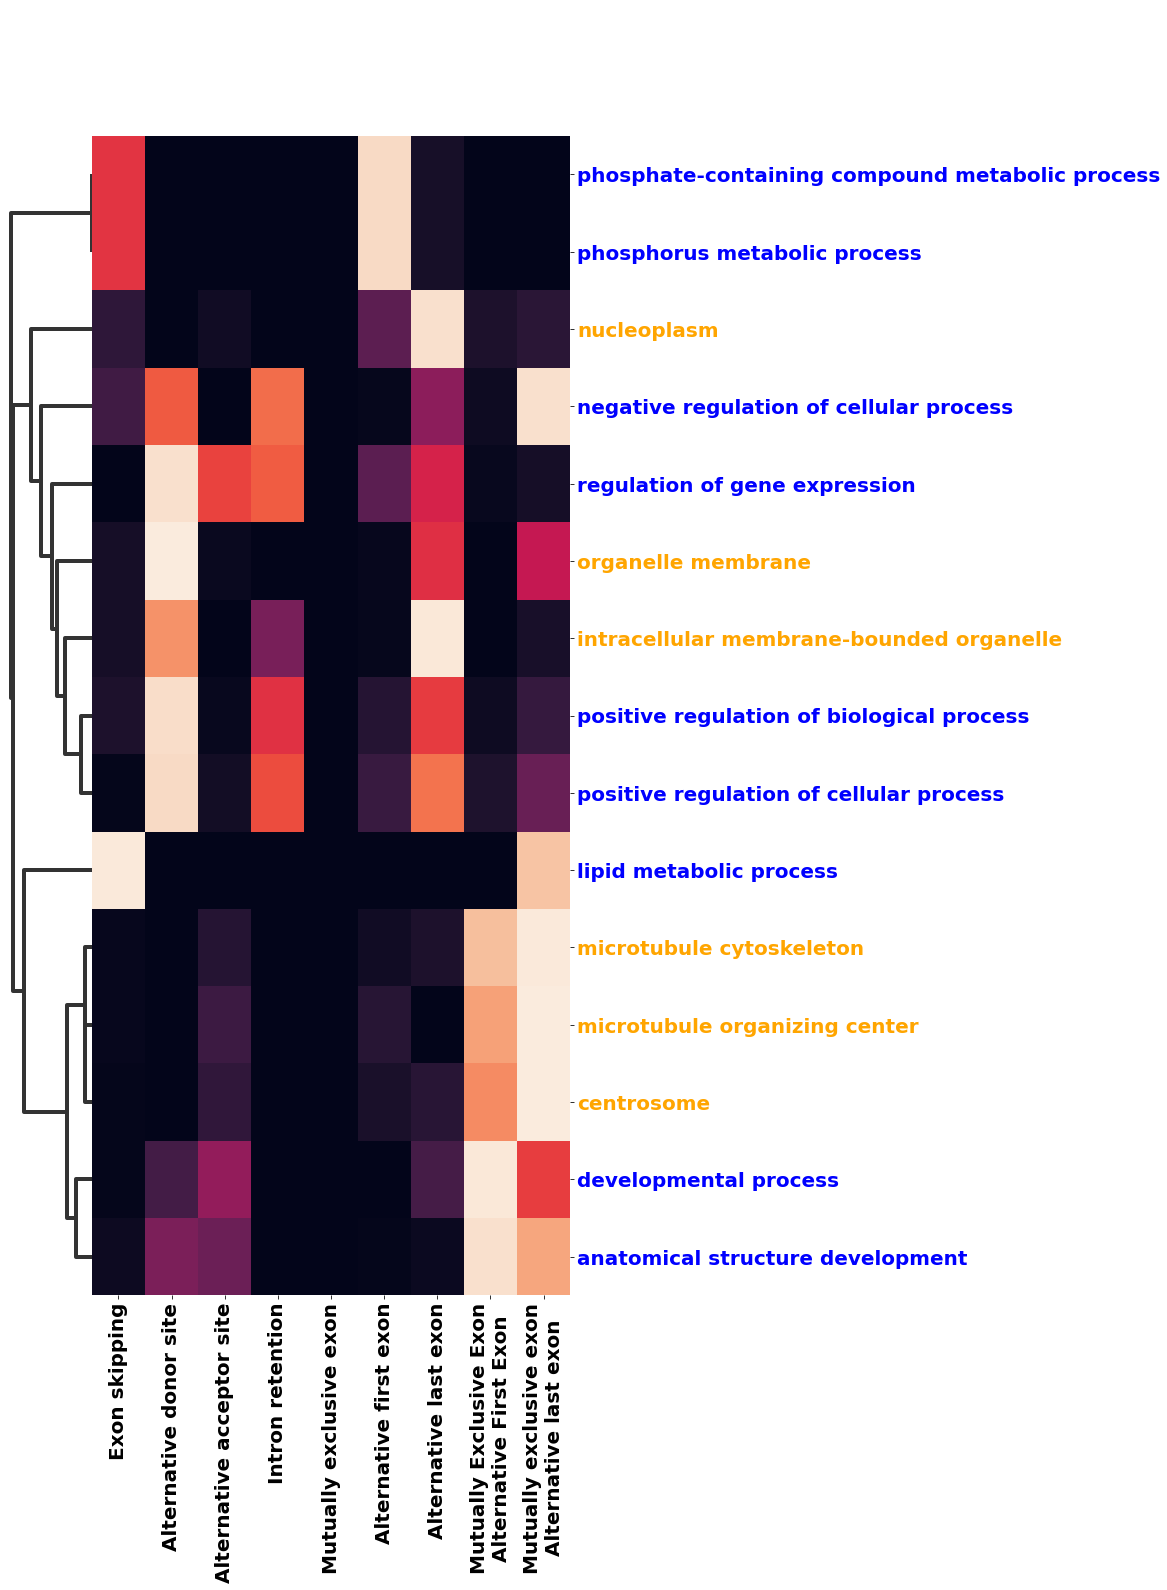

True

In [34]:
cluster_plot(go_obo,sign_gain_function_name)

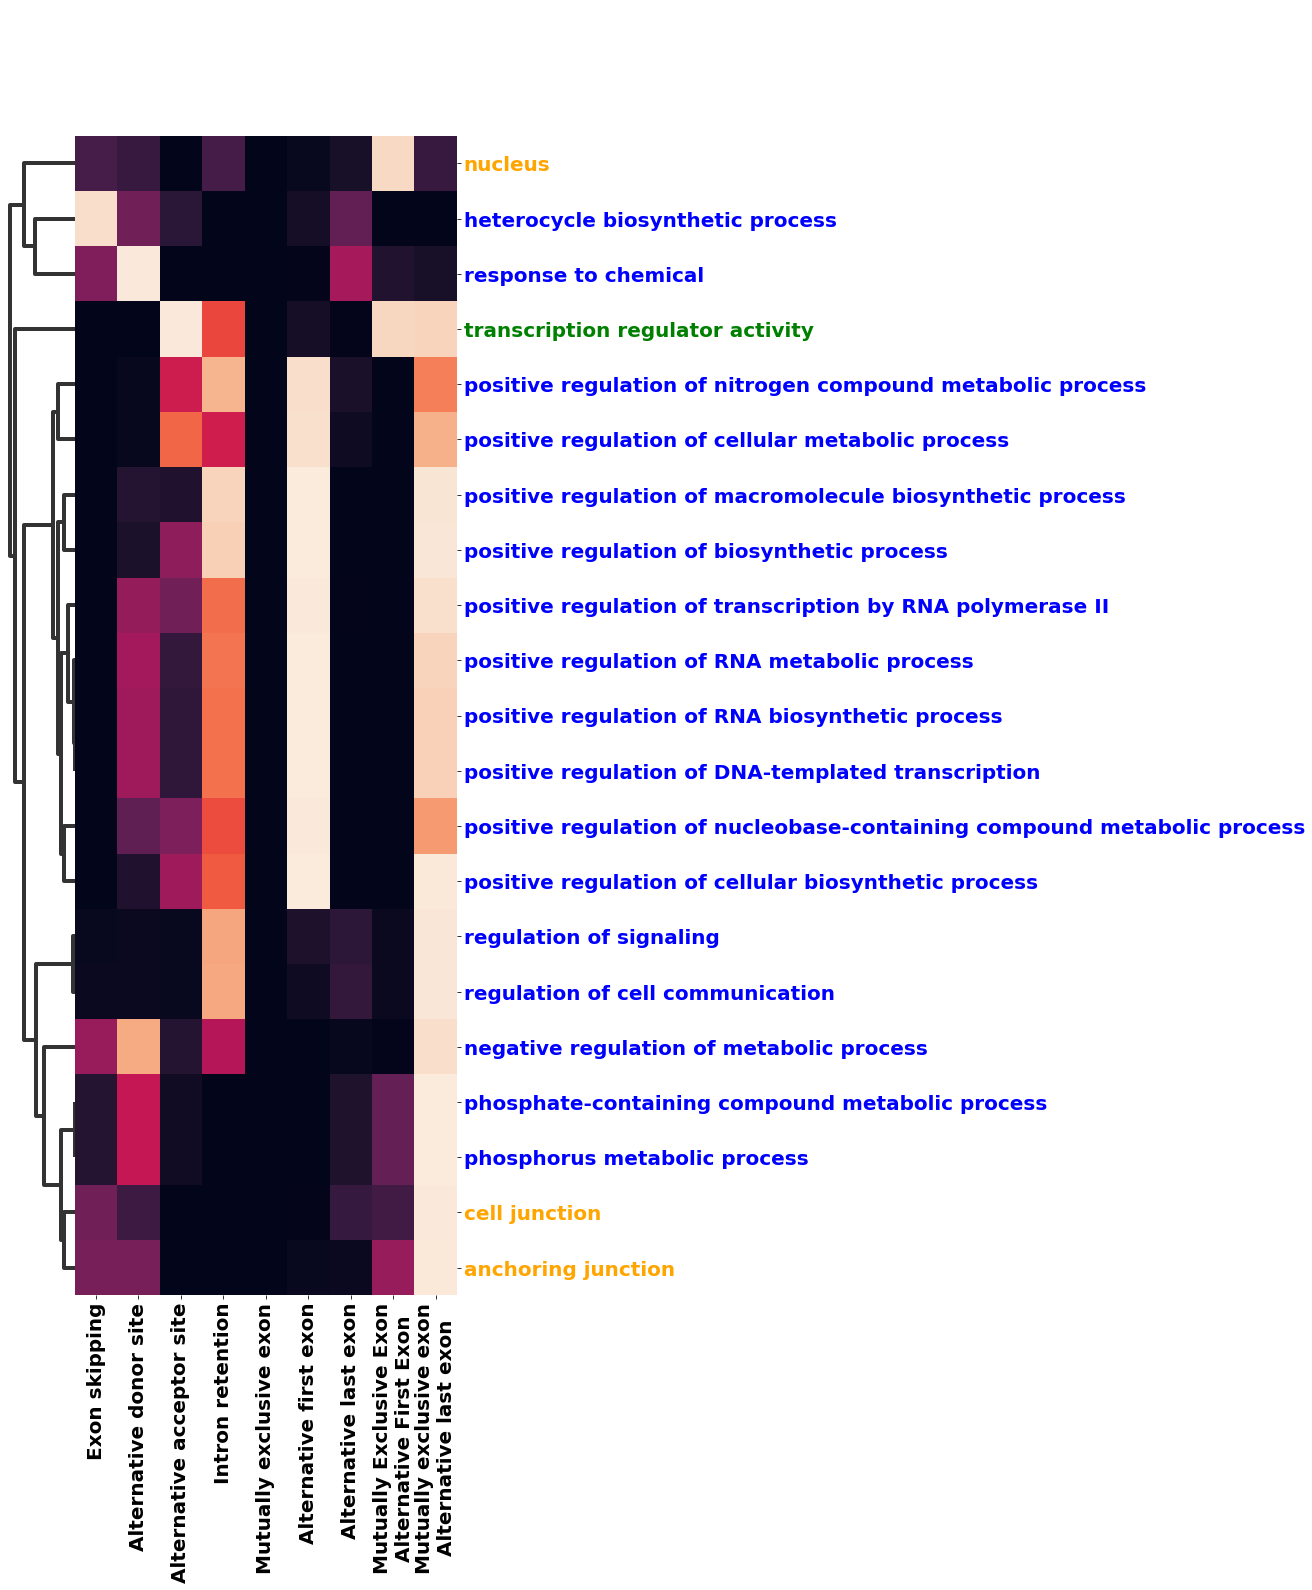

True

In [37]:
cluster_plot(go_obo,sign_lose_function_name)

<span style="font-size: 20px;">Plot for loss of function example: TPTE2 and TAFAZZIN</span>

In [6]:
non_HE_isoform_path = '../data/txt/non_HE_isoform.txt'

In [7]:
non_HE_isoform = []
with open(non_HE_isoform_path,'r') as f:
    for line in f:
        line = line.replace('\n','')
        non_HE_isoform.append(line)
f.close()

In [12]:
#load predicted probability file
isoform_go_df = pd.read_csv(isoform_go_prob_path, sep='\t', header=None)
isoform_go_df.columns=['uniprot entry','go terms','probability']
reference_go_df = pd.read_csv(reference_go_prob_path, sep='\t', header=None)
reference_go_df.columns=['uniprot entry','go terms','probability']

In [15]:
isoform_go_df_non_HE = isoform_go_df[isoform_go_df['uniprot entry'].isin(non_HE_isoform)].reset_index(drop=True)

In [16]:
isoform_go_df_non_HE['uniprot entry'].nunique()

1356

In [17]:
#O43598-2(low), P34913-2, O43678-2(mutation),O60671-2(*),O75608-2(no information),O95278-2
#helix: O95925-2,P01241-2,P01242-3
for isoform in isoform_go_df_non_HE['uniprot entry'].unique():
    reference = isoform.split('-')[0]
    go_list=list(set(reference_go[reference])-set(isoform_go[isoform]))
    if len(go_list)>5:
        print(isoform)
        print(reference)
        for i in go_list:
            go_function = extract_name_and_namespace(go_obo,i)
            print(go_function)
        #print(go_list)

A8MT69-2
A8MT69
('chromosome', 'cellular_component')
('nuclear protein-containing complex', 'cellular_component')
('membrane-enclosed lumen', 'cellular_component')
('intracellular non-membrane-bounded organelle', 'cellular_component')
('response to stimulus', 'biological_process')
('nuclear lumen', 'cellular_component')
('intracellular organelle lumen', 'cellular_component')
('organelle lumen', 'cellular_component')
('chromatin', 'cellular_component')
('non-membrane-bounded organelle', 'cellular_component')
O14682-2
O14682
('Cul3-RING ubiquitin ligase complex', 'cellular_component')
('ubiquitin ligase complex', 'cellular_component')
('intracellular organelle', 'cellular_component')
('protein metabolic process', 'biological_process')
('intracellular protein-containing complex', 'cellular_component')
('catalytic complex', 'cellular_component')
('transferase complex', 'cellular_component')
('cullin-RING ubiquitin ligase complex', 'cellular_component')
('cytoplasm', 'cellular_component')
(

('protein homodimerization activity', 'molecular_function')
('rough endoplasmic reticulum membrane', 'cellular_component')
('glycogen biosynthetic process', 'biological_process')
('identical protein binding', 'molecular_function')
('regulation of metabolic process', 'biological_process')
('organelle subcompartment', 'cellular_component')
('rough endoplasmic reticulum', 'cellular_component')
('endoplasmic reticulum', 'cellular_component')
('carbohydrate binding', 'molecular_function')
('negative regulation of metabolic process', 'biological_process')
('protein dephosphorylation', 'biological_process')
('biosynthetic process', 'biological_process')
('macromolecule biosynthetic process', 'biological_process')
('nucleoplasm', 'cellular_component')
('polysaccharide biosynthetic process', 'biological_process')
('peptidyl-tyrosine dephosphorylation', 'biological_process')
('glucan biosynthetic process', 'biological_process')
('dephosphorylation', 'biological_process')
('carbohydrate phosphata

('defense response to bacterium', 'biological_process')
('negative regulation of locomotion', 'biological_process')
('response to stimulus', 'biological_process')
('regulation of metal ion transport', 'biological_process')
('negative regulation of cilium-dependent cell motility', 'biological_process')
('protein-containing complex', 'cellular_component')
('regulation of cell motility', 'biological_process')
('negative regulation of transport', 'biological_process')
('regulation of molecular function', 'biological_process')
('negative regulation of cilium movement', 'biological_process')
('response to stress', 'biological_process')
('regulation of cilium-dependent cell motility', 'biological_process')
('response to external biotic stimulus', 'biological_process')
('regulation of transport', 'biological_process')
('regulation of macromolecule metabolic process', 'biological_process')
('defense response to other organism', 'biological_process')
('regulation of nitrogen compound metabolic p

('regulation of developmental process', 'biological_process')
('cellular response to organic substance', 'biological_process')
P01242-3
P01242
('response to endogenous stimulus', 'biological_process')
('endosome lumen', 'cellular_component')
('response to hormone', 'biological_process')
('animal organ development', 'biological_process')
('regulation of multicellular organismal process', 'biological_process')
('endosome', 'cellular_component')
('cellular response to chemical stimulus', 'biological_process')
('response to oxygen-containing compound', 'biological_process')
P06865-2
P06865
('ganglioside catabolic process', 'biological_process')
('liposaccharide metabolic process', 'biological_process')
('glycosphingolipid metabolic process', 'biological_process')
('cellular lipid catabolic process', 'biological_process')
('glycosphingolipid catabolic process', 'biological_process')
('lipid metabolic process', 'biological_process')
('sphingolipid catabolic process', 'biological_process')
('

('positive regulation of mononuclear cell proliferation', 'biological_process')
('regulation of interleukin-2 production', 'biological_process')
('regulation of gene expression', 'biological_process')
('cell activation', 'biological_process')
('positive regulation of multicellular organismal process', 'biological_process')
('leukocyte activation', 'biological_process')
('lymphocyte activation', 'biological_process')
('positive regulation of cell population proliferation', 'biological_process')
('anatomical structure development', 'biological_process')
('mononuclear cell differentiation', 'biological_process')
('positive regulation of biological process', 'biological_process')
('positive regulation of leukocyte proliferation', 'biological_process')
('side of membrane', 'cellular_component')
('cellular response to stimulus', 'biological_process')
('regulation of macromolecule metabolic process', 'biological_process')
('positive regulation of T cell activation', 'biological_process')
('po

('nuclear outer membrane-endoplasmic reticulum membrane network', 'cellular_component')
('positive regulation of biological process', 'biological_process')
('positive regulation of immune system process', 'biological_process')
('positive regulation of immune response', 'biological_process')
('endomembrane system', 'cellular_component')
('regulation of cell killing', 'biological_process')
('regulation of adaptive immune response', 'biological_process')
('positive regulation of immune effector process', 'biological_process')
('negative regulation of cellular process', 'biological_process')
P20839-2
P20839
('membrane-enclosed lumen', 'cellular_component')
('intracellular vesicle', 'cellular_component')
('intracellular organelle lumen', 'cellular_component')
('vesicle', 'cellular_component')
('organelle lumen', 'cellular_component')
('cytoplasmic vesicle', 'cellular_component')
P23510-2
P23510
('positive regulation of interleukin-6 production', 'biological_process')
('positive regulation o

('cellular component organization', 'biological_process')
('supramolecular complex', 'cellular_component')
('cellular component assembly', 'biological_process')
('actin filament bundle organization', 'biological_process')
('supramolecular polymer', 'cellular_component')
('supramolecular fiber organization', 'biological_process')
('actin filament', 'cellular_component')
('actin filament-based process', 'biological_process')
('actin filament organization', 'biological_process')
('intracellular non-membrane-bounded organelle', 'cellular_component')
('polymeric cytoskeletal fiber', 'cellular_component')
('supramolecular fiber', 'cellular_component')
('cellular component organization or biogenesis', 'biological_process')
('actin cytoskeleton organization', 'biological_process')
('actin filament bundle assembly', 'biological_process')
('cellular response to stimulus', 'biological_process')
('protein-containing complex binding', 'molecular_function')
('cytoskeleton', 'cellular_component')
('c

('positive regulation of cell adhesion', 'biological_process')
('regulation of metabolic process', 'biological_process')
('cell surface receptor signaling pathway', 'biological_process')
('regulation of cell activation', 'biological_process')
('regulation of cytokine production', 'biological_process')
('positive regulation of leukocyte activation', 'biological_process')
('regulation of leukocyte activation', 'biological_process')
('signaling', 'biological_process')
('signaling receptor activity', 'molecular_function')
('organic substance transport', 'biological_process')
('positive regulation of cell activation', 'biological_process')
('establishment of localization', 'biological_process')
('nitrogen compound transport', 'biological_process')
('transport', 'biological_process')
('cell communication', 'biological_process')
('regulation of cell adhesion', 'biological_process')
('regulation of gene expression', 'biological_process')
('positive regulation of multicellular organismal proces

('negative regulation of behavior', 'biological_process')
('response to starvation', 'biological_process')
('negative regulation of metabolic process', 'biological_process')
('negative regulation of circadian rhythm', 'biological_process')
('response to extracellular stimulus', 'biological_process')
('post-transcriptional gene silencing', 'biological_process')
('regulation of circadian sleep/wake cycle', 'biological_process')
('negative regulation of multicellular organismal process', 'biological_process')
('response to stimulus', 'biological_process')
('negative regulation of biological process', 'biological_process')
('post-transcriptional regulation of gene expression', 'biological_process')
('regulation of gene expression', 'biological_process')
('regulation of circadian sleep/wake cycle, sleep', 'biological_process')
('regulation of biological quality', 'biological_process')
('regulation of behavior', 'biological_process')
('response to stress', 'biological_process')
('protein sta

('binding', 'molecular_function')
('phosphate-containing compound metabolic process', 'biological_process')
('membrane', 'cellular_component')
('biosynthetic process', 'biological_process')
('cellular biosynthetic process', 'biological_process')
Q7RTP0-2
Q7RTP0
('magnesium ion transmembrane transporter activity', 'molecular_function')
('monoatomic cation transmembrane transporter activity', 'molecular_function')
('monoatomic ion transmembrane transporter activity', 'molecular_function')
('metal ion transmembrane transporter activity', 'molecular_function')
('cellular process', 'biological_process')
('inorganic cation transmembrane transporter activity', 'molecular_function')
('inorganic molecular entity transmembrane transporter activity', 'molecular_function')
Q7Z5A7-3
Q7Z5A7
('regulation of cell population proliferation', 'biological_process')
('signaling receptor regulator activity', 'molecular_function')
('regulation of smooth muscle cell migration', 'biological_process')
('negativ

('negative regulation of single stranded viral RNA replication via double stranded DNA intermediate', 'biological_process')
('regulation of single stranded viral RNA replication via double stranded DNA intermediate', 'biological_process')
('non-membrane-bounded organelle', 'cellular_component')
Q8IXQ5-4
Q8IXQ5
('nitrogen compound metabolic process', 'biological_process')
('organonitrogen compound metabolic process', 'biological_process')
('ubiquitin ligase complex', 'cellular_component')
('protein metabolic process', 'biological_process')
('intracellular protein-containing complex', 'cellular_component')
('catalytic complex', 'cellular_component')
('transferase complex', 'cellular_component')
('cullin-RING ubiquitin ligase complex', 'cellular_component')
('cytoplasm', 'cellular_component')
('organic substance metabolic process', 'biological_process')
('metabolic process', 'biological_process')
('protein-containing complex', 'cellular_component')
('macromolecule metabolic process', 'bio

('membrane-bounded organelle', 'cellular_component')
('intracellular organelle', 'cellular_component')
('organelle', 'cellular_component')
('intracellular anatomical structure', 'cellular_component')
('cytoplasm', 'cellular_component')
('cellular process', 'biological_process')
Q8WU39-4
Q8WU39
('positive regulation of cell population proliferation', 'biological_process')
('regulation of cell population proliferation', 'biological_process')
('positive regulation of cellular process', 'biological_process')
('intracellular anatomical structure', 'cellular_component')
('positive regulation of biological process', 'biological_process')
('extracellular region', 'cellular_component')
('cytoplasm', 'cellular_component')
Q8WU39-5
Q8WU39
('positive regulation of cell population proliferation', 'biological_process')
('regulation of cell population proliferation', 'biological_process')
('positive regulation of cellular process', 'biological_process')
('intracellular anatomical structure', 'cellula

('positive regulation of response to stimulus', 'biological_process')
('obsolete negative regulation of cell death', 'biological_process')
('response to fungus', 'biological_process')
('regulation of macrophage colony-stimulating factor production', 'biological_process')
('regulation of programmed cell death', 'biological_process')
('positive regulation of peptidyl-tyrosine phosphorylation', 'biological_process')
('regulation of inflammatory response', 'biological_process')
('positive regulation of cell activation', 'biological_process')
('regulation of protein modification process', 'biological_process')
('response to biotic stimulus', 'biological_process')
('extracellular region', 'cellular_component')
('positive regulation of signal transduction', 'biological_process')
('positive regulation of response to external stimulus', 'biological_process')
('positive regulation of cellular metabolic process', 'biological_process')
('immune response', 'biological_process')
('positive regulatio

('organonitrogen compound catabolic process', 'biological_process')
('protein catabolic process', 'biological_process')
('macromolecule catabolic process', 'biological_process')
('modification-dependent macromolecule catabolic process', 'biological_process')
('modification-dependent protein catabolic process', 'biological_process')
('obsolete cellular macromolecule catabolic process', 'biological_process')
('cellular metabolic process', 'biological_process')
('catabolic process', 'biological_process')
('cellular catabolic process', 'biological_process')
('obsolete cellular macromolecule metabolic process', 'biological_process')
('organic substance catabolic process', 'biological_process')
('cellular response to stress', 'biological_process')
('ubiquitin-dependent protein catabolic process', 'biological_process')
('proteolysis involved in protein catabolic process', 'biological_process')
Q96PM5-6
Q96PM5
('zinc ion binding', 'molecular_function')
('protein modification by small protein c

('localization', 'biological_process')
('regulation of cellular biosynthetic process', 'biological_process')
('positive regulation of macromolecule metabolic process', 'biological_process')
('positive regulation of canonical NF-kappaB signal transduction', 'biological_process')
('regulation of multicellular organismal process', 'biological_process')
('regulation of cytokine production involved in inflammatory response', 'biological_process')
('positive regulation of gene expression', 'biological_process')
('response to interleukin-1', 'biological_process')
('cellular response to organic substance', 'biological_process')
('regulation of canonical NF-kappaB signal transduction', 'biological_process')
('positive regulation of cytokine production', 'biological_process')
Q9BRF8-2
Q9BRF8
('hydrolase activity', 'molecular_function')
('organic substance metabolic process', 'biological_process')
('metabolic process', 'biological_process')
('hydrolase activity, acting on ester bonds', 'molecular

('regulation of primary metabolic process', 'biological_process')
('negative regulation of metabolic process', 'biological_process')
('negative regulation of biosynthetic process', 'biological_process')
('regulation of RNA biosynthetic process', 'biological_process')
('negative regulation of macromolecule biosynthetic process', 'biological_process')
('obsolete regulation of nucleic acid-templated transcription', 'biological_process')
('regulation of DNA-templated transcription', 'biological_process')
('negative regulation of biological process', 'biological_process')
('regulation of macromolecule biosynthetic process', 'biological_process')
('regulation of gene expression', 'biological_process')
('regulation of transcription by RNA polymerase II', 'biological_process')
('negative regulation of RNA metabolic process', 'biological_process')
('negative regulation of cellular biosynthetic process', 'biological_process')
('regulation of biosynthetic process', 'biological_process')
('negativ

('ribose phosphate metabolic process', 'biological_process')
('ribose phosphate biosynthetic process', 'biological_process')
('nucleoside phosphate metabolic process', 'biological_process')
Q9NV96-2
Q9NV96
('positive regulation of protein localization', 'biological_process')
('regulation of localization', 'biological_process')
('aminophospholipid transport', 'biological_process')
('regulation of protein transport', 'biological_process')
('regulation of cellular localization', 'biological_process')
('positive regulation of intracellular protein transport', 'biological_process')
('positive regulation of protein exit from endoplasmic reticulum', 'biological_process')
('positive regulation of intracellular transport', 'biological_process')
('positive regulation of establishment of protein localization', 'biological_process')
('regulation of transport', 'biological_process')
('regulation of intracellular protein transport', 'biological_process')
('positive regulation of protein transport', 

('extracellular space', 'cellular_component')
('intracellular vesicle', 'cellular_component')
('extracellular organelle', 'cellular_component')
('extracellular membrane-bounded organelle', 'cellular_component')
('extracellular region', 'cellular_component')
('extracellular vesicle', 'cellular_component')
('extracellular exosome', 'cellular_component')
('secretory vesicle', 'cellular_component')
('endomembrane system', 'cellular_component')
('cytoplasmic vesicle', 'cellular_component')
Q9Y6J8-4
Q9Y6J8
('mitochondrion', 'cellular_component')
('regulation of signaling', 'biological_process')
('regulation of cellular metabolic process', 'biological_process')
('regulation of metabolic process', 'biological_process')
('regulation of primary metabolic process', 'biological_process')
('negative regulation of metabolic process', 'biological_process')
('regulation of intracellular signal transduction', 'biological_process')
('signaling', 'biological_process')
('response to stimulus', 'biological

In [40]:
#TPTE2
go_list=list(set(reference_go['Q6XPS3'])-set(isoform_go['Q6XPS3-4']))
#go_list.remove('GO:0043226')
#go_list.remove('GO:0043229')

In [13]:
#EPHX2
go_list=list(set(reference_go['P34913'])-set(isoform_go['P34913-2']))
#remove the redundant go terms
go_list.remove('GO:0005488')
go_list.remove('GO:0044238')
go_list.remove('GO:0009056')

In [14]:
go_list

['GO:0005515', 'GO:0016788', 'GO:1901575', 'GO:0006629']

In [15]:
def replace_go_df(go_data,plot_df):
    new_index_list=[]
    for index in range(len(plot_df['go terms'])):
        go=plot_df['go terms'][index]
        term_name=extract_name_and_namespace(go_data,go)[0]
        plot_df['go terms'][index]=term_name
    return plot_df

In [23]:
def plot_example_go_seperate(entry_go_df,entry,go_list,go_data,reference=True,gene_name=None):
    plot_df=entry_go_df[(entry_go_df['uniprot entry']==entry) & 
                                     (entry_go_df['go terms'].isin(go_list))].reset_index(drop=True)
    plot_df=replace_go_df(go_data,plot_df)
    plot_df = plot_df.sort_values(by='go terms', ascending=True)
    if reference==True:
        plt.figure(figsize=(10,6))
        custom_palette = ["#F3BF70"]
        sns.barplot(x='probability',y='go terms',data=plot_df,palette=custom_palette)
        plt.xlim(0.4,0.75)
        plt.gca().axes.get_xaxis().set_visible(False)
        sns.despine(left=True, bottom=True)
        #plt.yticks(fontsize=18,fontweight='bold')
        plt.yticks(fontsize=18)
        plt.ylabel('')
        reference_name = 'reference'
        plt.savefig(gene_name+'_'+reference_name+'.png',dpi=600,bbox_inches='tight')
        plt.show()
    else:
        plt.figure(figsize=(10,6))
        custom_palette = ["#25D9F5"]
        sns.barplot(x='probability',y='go terms',data=plot_df,palette=custom_palette)
        plt.xlim(0.4,0.75)
        sns.despine(left=True)
        #plt.yticks(fontsize=18,fontweight='bold')
        #plt.xticks(fontsize=18,fontweight='bold')
        plt.yticks(fontsize=18)
        plt.xticks(fontsize=18)
        plt.xlabel('Probability',fontsize=20)
        plt.ylabel('')
        reference_name = 'isoform'
        plt.savefig(gene_name+'_'+reference_name+'.png',dpi=600,bbox_inches='tight')
        plt.show()
    return plot_df

In [13]:
extract_name_and_namespace(go_obo,'GO:0072523')

('purine-containing compound catabolic process', 'biological_process')

/tmp/ipykernel_2703700/829424608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['go terms'][index]=term_name
/tmp/ipykernel_2703700/2468495548.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='probability',y='go terms',data=plot_df,palette=custom_palette)
/tmp/ipykernel_2703700/2468495548.py:9: UserWarning: 
The palette list has fewer values (1) than needed (10) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x='probability',y='go terms',data=plot_df,palette=custom_palette)


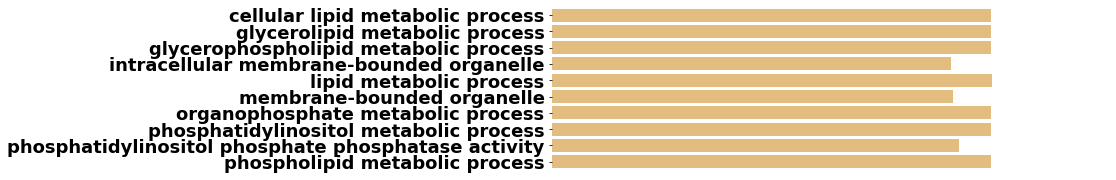

In [44]:
plot_reference_df=plot_example_go_seperate(reference_go_df,'Q6XPS3',go_list,go_obo)

/tmp/ipykernel_2155264/829424608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['go terms'][index]=term_name


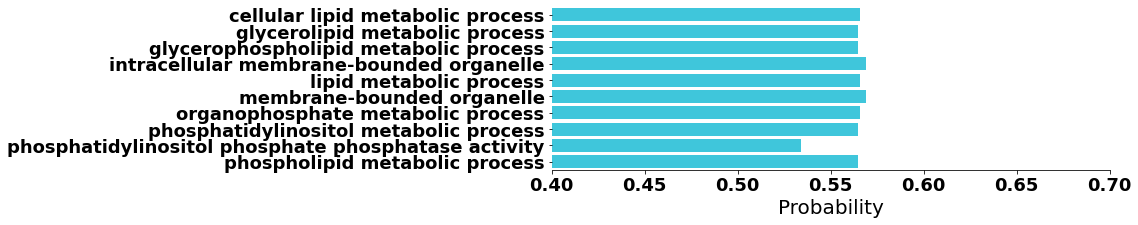

In [78]:
plot_isoform_df=plot_example_go_seperate(isoform_go_df,'Q6XPS3-4',go_list,go_obo,reference=False)

/tmp/ipykernel_2844494/829424608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['go terms'][index]=term_name


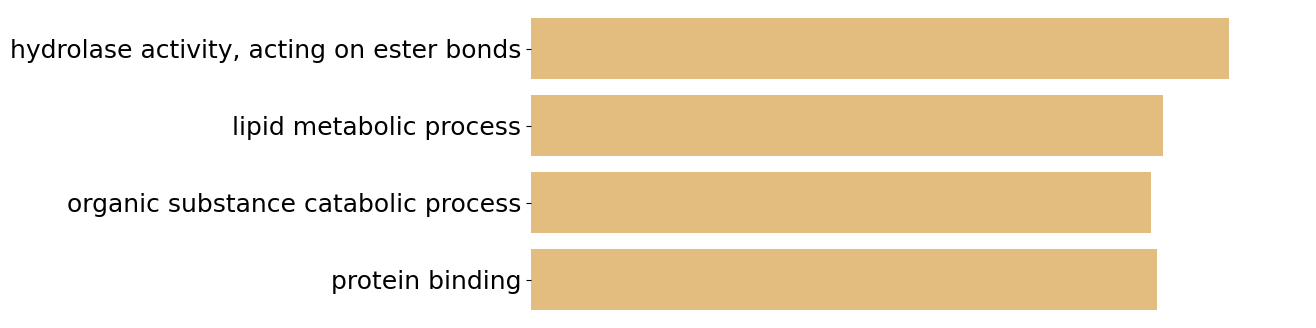

In [20]:
plot_reference_df=plot_example_go_seperate(reference_go_df,'P34913',go_list,go_obo,reference=True,gene_name='EPHX2')

/tmp/ipykernel_2844494/829424608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['go terms'][index]=term_name


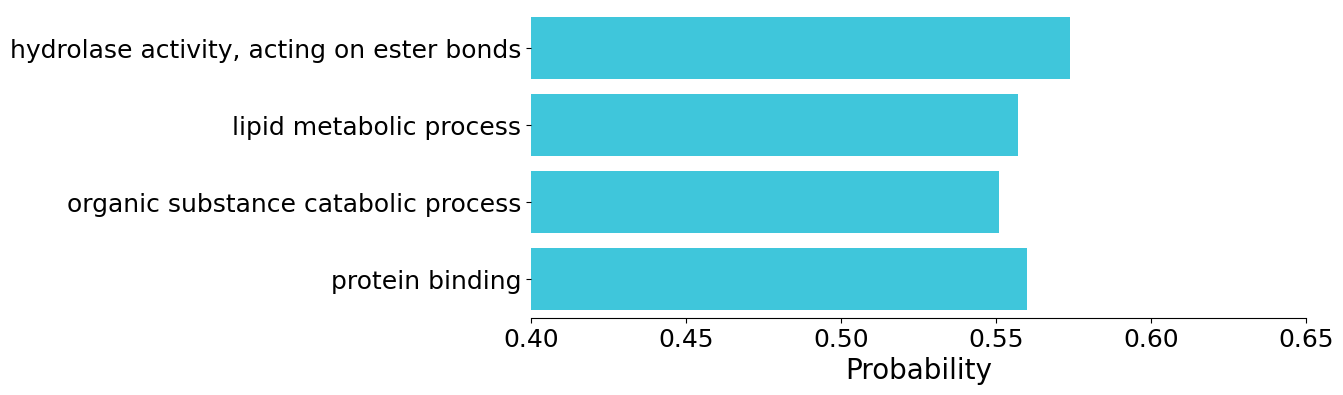

In [21]:
plot_isoform_df=plot_example_go_seperate(isoform_go_df,'P34913-2',go_list,go_obo,reference=False,gene_name='EPHX2')

In [22]:
#TAFAZZIN
go_list=list(set(reference_go['Q16635'])-set(isoform_go['Q16635-7']))
go_list.remove('GO:0048468')
go_list.remove('GO:0048869')
go_list.remove('GO:0030154')

/tmp/ipykernel_2844494/829424608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['go terms'][index]=term_name


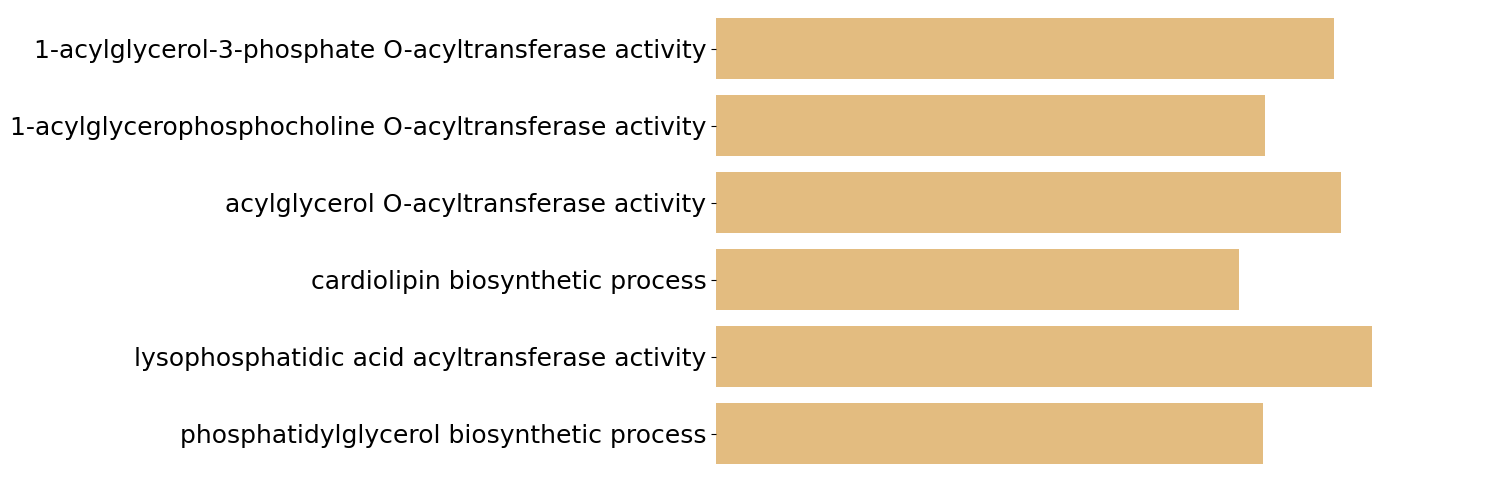

In [24]:
plot_reference_df=plot_example_go_seperate(reference_go_df,'Q16635',go_list,go_obo,reference=True,gene_name='TAFAZZIN')

/tmp/ipykernel_2844494/829424608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['go terms'][index]=term_name


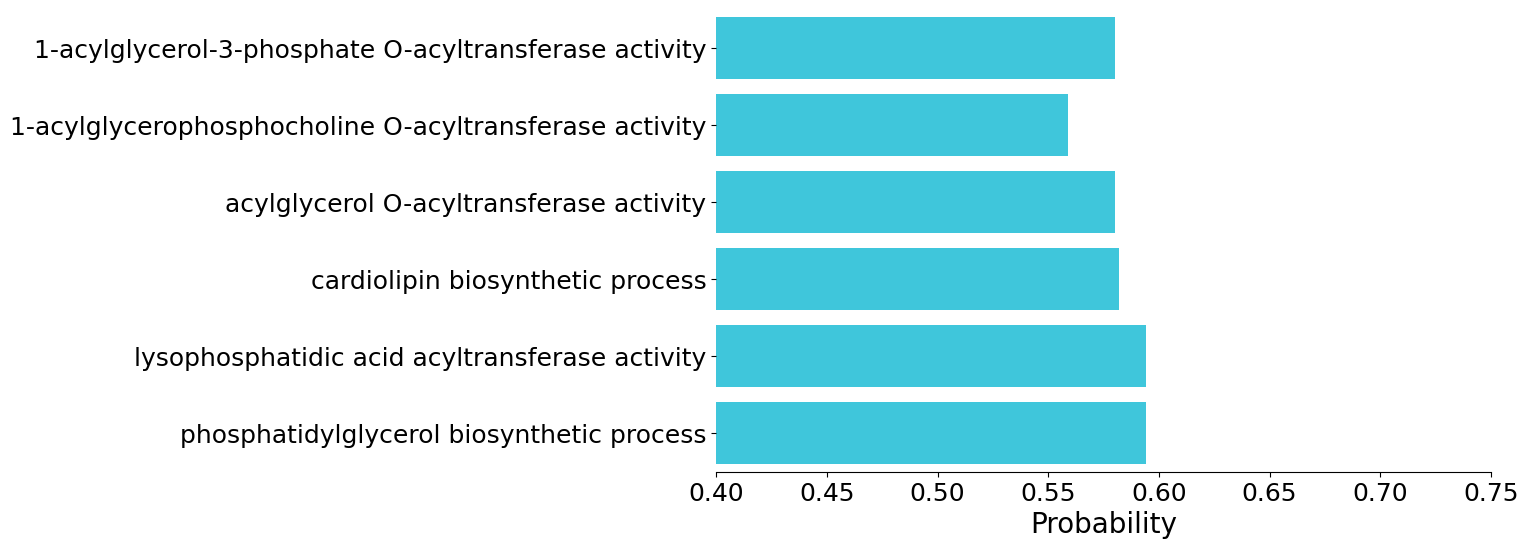

In [25]:
plot_isoform_df=plot_example_go_seperate(isoform_go_df,'Q16635-7',go_list,go_obo,reference=False,gene_name='TAFAZZIN')